# Import Statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import sys
sys.path.append('/cvmfs/icecube.opensciencegrid.org/py3-v4.3.0/RHEL_7_x86_64/lib/python3.11/site-packages/')
import photospline
from photospline import glam_fit, ndsparse, bspline

import site
sys.path.append(site.USER_SITE)
import uproot
from scipy.interpolate import interp1d
from scipy.stats import norm, kstest
from scipy.stats import ks_2samp
import healpy as hp
import glob
import time

# HAWC - Loading and reading the data

In [2]:
elements = ["proton", "helium", "carbon", "oxygen", "neon", "magnesium", "silicon", "iron"]

files = sorted(glob.glob("pass5.1/*.root"))

main_dict = {e: {} for e in elements}

for e in elements:
    data_candidates = [file for file in files if (e in file) and ('mc' not in file)]
    weight_candidates = [file for file in files if (e in file) and ('mc' in file)]

    # reading the data files
    if len(data_candidates) == 1:
        data_file = data_candidates[0]
        with uproot.open(data_file) as f:
            t = f["XCDF"]
            main_dict[e]["nChAvail"] = t["rec.nChAvail"].array(library="np")
            main_dict[e]["nHit"]      = t["rec.nHit"].array(library="np")
            main_dict[e]["CxPE40XnCh"] = t["rec.CxPE40XnCh"].array(library="np")
            main_dict[e]["corsikaParticleId"] = t["mc.corsikaParticleId"].array(library="np")
            main_dict[e]["zenith"]   = t["rec.zenithAngle"].array(library="np")
            main_dict[e]["coreX"]    = t["rec.coreX"].array(library="np")
            main_dict[e]["coreY"]    = t["rec.coreY"].array(library="np")
            main_dict[e]["coreR"] = np.sqrt((main_dict[e]["coreX"]-37.19)**2+(main_dict[e]["coreY"]-246)**2)/100.
            main_dict[e]["pinc"]     = t["rec.PINC"].array(library="np")
            main_dict[e]["trueEnergy"] = t["mc.logEnergy"].array(library="np")
            # t.show()

    # read the weights files
    if len(weight_candidates) ==1:
        weight_file = weight_candidates[0]
        with uproot.open(weight_file) as f:
            t = f["XCDF"]
            main_dict[e]["gsf"] = t["sweets.IWgt.gsf"].array(library="np")
            main_dict[e]["h3a"] = t["sweets.IWgt.h3a"].array(library="np")

    # defining the initial cuts
    initial_cut = np.logical_and(main_dict[e]["nHit"] > 75, main_dict[e]["zenith"] >= 0)
    initial_cut = np.logical_and(initial_cut, main_dict[e]["zenith"] < 1.222)
    initial_cut = np.logical_and(initial_cut, main_dict[e]["CxPE40XnCh"] > 40)

    # applied the initial cuts here to all the arrays
    for key in main_dict[e].keys():
        main_dict[e][key] = main_dict[e][key][initial_cut]

In [3]:
main_dict

{'proton': {'nChAvail': array([1066,  999, 1074, ..., 1063, 1070,  988], dtype=uint64),
  'nHit': array([333, 998,  86, ..., 235, 110, 976], dtype=uint64),
  'CxPE40XnCh': array([ 99, 211,  65, ..., 112,  57, 135], dtype=uint64),
  'corsikaParticleId': array([14, 14, 14, ..., 14, 14, 14], dtype=uint64),
  'zenith': array([0.1919, 0.2421, 0.0982, ..., 0.727 , 0.8772, 0.0877]),
  'coreX': array([73.4, 29.9, 97.5, ..., 94. , 35.6, 99.1]),
  'coreY': array([176.3, 246.7, 276.2, ..., 255. , 179.8, 262.6]),
  'coreR': array([0.78544599, 0.07323531, 0.67448766, ..., 0.57518485, 0.66219092,
         0.64096865]),
  'pinc': array([3.09, 2.43, 1.46, ..., 1.74, 0.81, 2.37]),
  'trueEnergy': array([3.592, 5.111, 2.494, ..., 3.657, 3.863, 5.075]),
  'gsf': array([1.03459167e-03, 6.58024165e-05, 8.19134620e-04, ...,
         9.65951095e-05, 1.05589482e-03, 1.33738021e-05]),
  'h3a': array([1.05252091e-03, 6.69624836e-05, 8.06668809e-04, ...,
         9.69478026e-05, 1.02743641e-03, 1.36929351e-05])}

In [4]:
# zenith, nHit, nChAvail, coreR, true energy, corsikaParticleID, pinc, gsf, h3a

zenith, nHit, nChAvail, coreR, log_true_E, particleId, pinc, gsf, h3a = [], [], [], [], [], [], [], [], []

for e in main_dict.keys():
    zenith.append(main_dict[e]["zenith"])
    nHit.append(main_dict[e]["nHit"])
    nChAvail.append(main_dict[e]["nChAvail"])
    coreR.append(main_dict[e]["coreR"])
    log_true_E.append(main_dict[e]["trueEnergy"])
    particleId.append(main_dict[e]["corsikaParticleId"])
    pinc.append(main_dict[e]["pinc"])
    gsf.append(main_dict[e]["gsf"])
    h3a.append(main_dict[e]["h3a"])

zenith = np.concatenate(zenith)
nHit = np.concatenate(nHit)
nChAvail = np.concatenate(nChAvail)
coreR = np.concatenate(coreR)
log_true_E = np.concatenate(log_true_E)
particleId = np.concatenate(particleId)
pinc = np.concatenate(pinc)
gsf = np.concatenate(gsf)
h3a = np.concatenate(h3a)

# HAWC - Calculate the reco energy

In [5]:
def get_reco_energy(zenith, nHit, nChAvail, coreR):
    tab1 = photospline.SplineTable(f'pass5_spline_combined3d.fits')
    x = np.cos(zenith)
    y = nHit/nChAvail
    z = coreR

    reco_energy = []

    for i in range(x.size):
        coord3d = [x[i], y[i], z[i]]
        try:
            centers = tab1.search_centers(coord3d)
            reco_energy.append(tab1.evaluate(coord3d, centers))
        except:
            reco_energy.append(-1)

    reco_energy = np.array(reco_energy)

    return reco_energy

In [6]:
reco_energy = get_reco_energy(zenith, nHit, nChAvail, coreR)

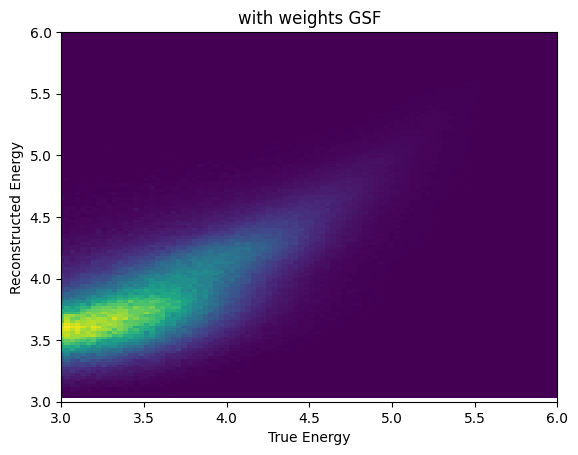

In [7]:
# visualize the reco energy and true energy relation
plt.hist2d(log_true_E, reco_energy, bins = 150, weights = gsf)
plt.ylim(3,6)
plt.xlim(3,6)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights GSF')
plt.show()

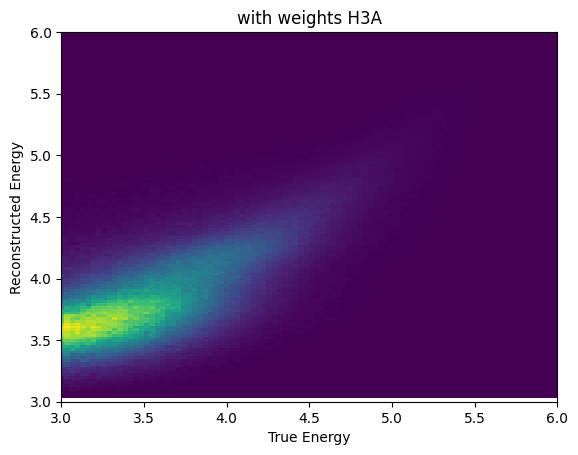

In [8]:
# visualize the reco energy and true energy relation
plt.hist2d(log_true_E, reco_energy, bins = 150, weights = h3a)
plt.ylim(3,6)
plt.xlim(3,6)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights H3A')
plt.show()

# HAWC - Converting particle IDs to atomic numbers

In [9]:
particle_ids = {14: 1, 402 : 2, 1206 : 6, 2412: 12, 2010 : 10, 1608: 8, 2814: 14, 5626: 26}

In [10]:
atomic_number = []
for i in particleId:
    atomic_number.append(particle_ids[i])

atomic_number = np.array(atomic_number)
log_atomic_number = np.log10(atomic_number)

In [11]:
rigidity = log_true_E - log_atomic_number

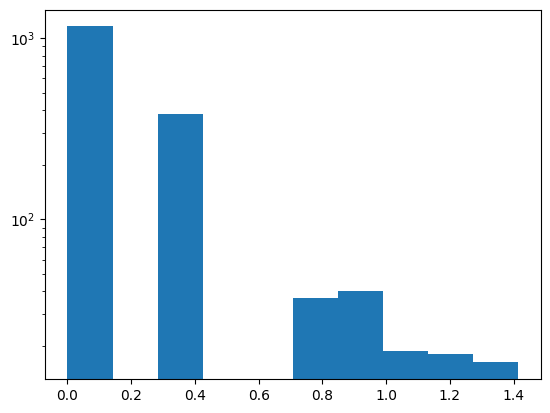

In [12]:
plt.hist(np.log10(atomic_number), weights = gsf)
plt.yscale('log')
plt.show()

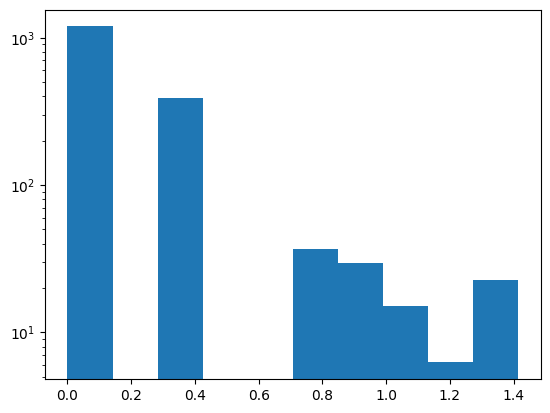

In [13]:
plt.hist(np.log10(atomic_number), weights = h3a)
plt.yscale('log')
plt.show()

In [14]:
# mean_logz = np.average(np.log10(atomic_number), weights = weights)
# mean_logz

# HAWC - Energy cuts on reco energy applied to true energy

- 12 total cuts going from bin0 to bin11

In [15]:
min_energies = [3.0, 3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.88, 5.15, 5.44, 5.68, 6.0]
max_energies = [3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.98, 5.15, 5.44, 5.68, 6.0, 6.9]
pinc_vals = [1.3, 1.4, 1.5, 1.4, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]

In [16]:
def cut_energy(min_energy, max_energy, pinc_val):
    cut = np.logical_and(min_energy <= reco_energy, max_energy > reco_energy)
    cut = np.logical_and(cut, pinc > pinc_val)

    return cut

In [17]:
cuts = []

for i , j , k in zip(min_energies, max_energies, pinc_vals):
    cut = cut_energy(i, j , k)
    cuts.append(cut)

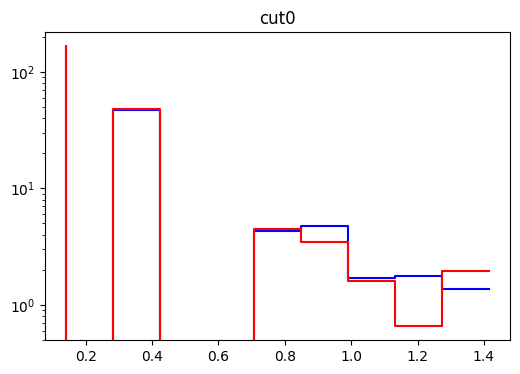

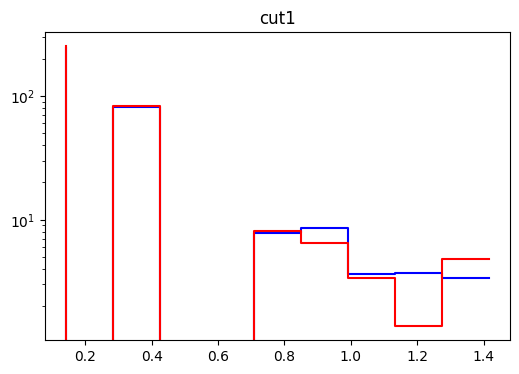

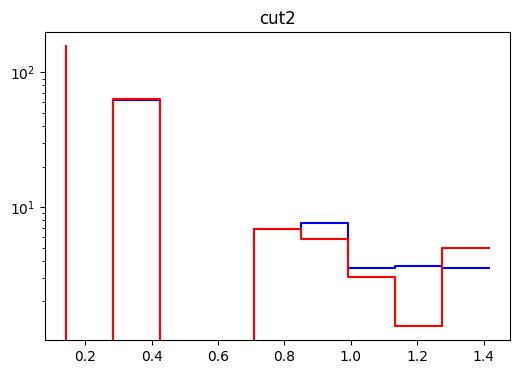

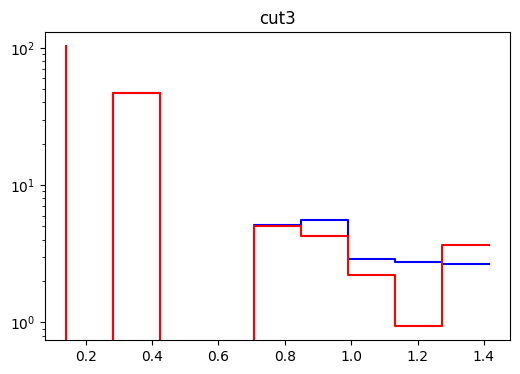

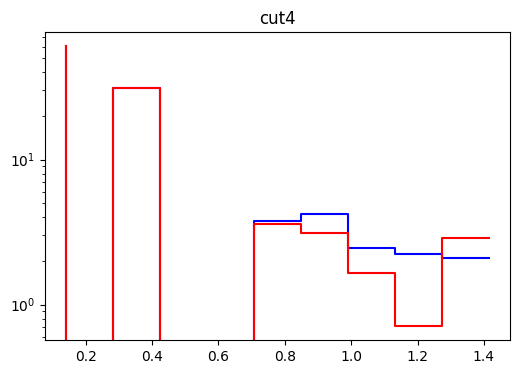

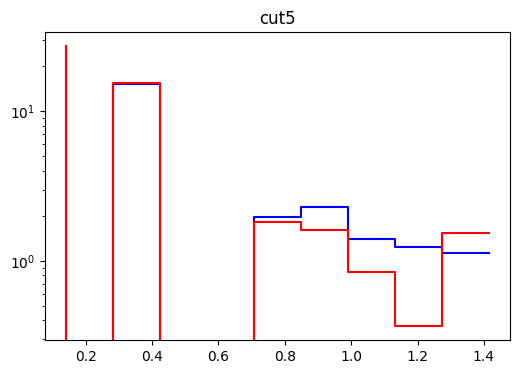

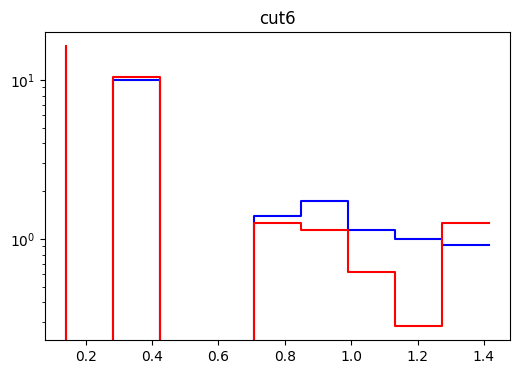

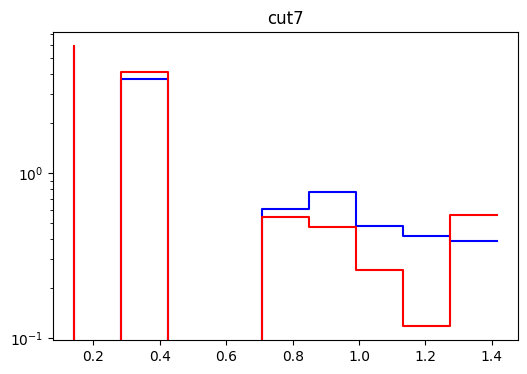

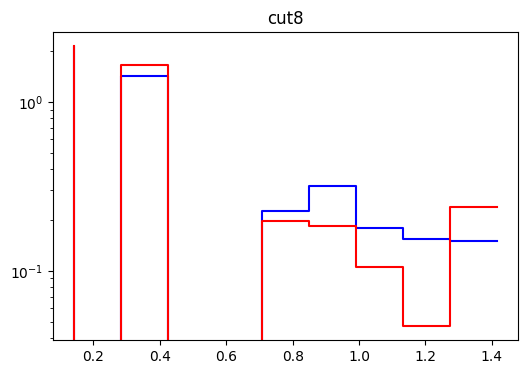

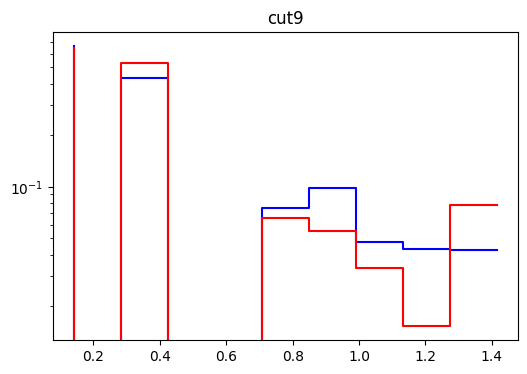

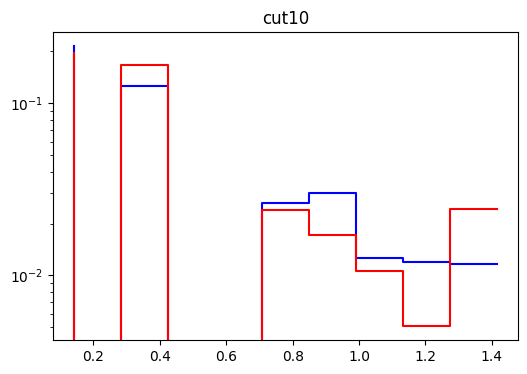

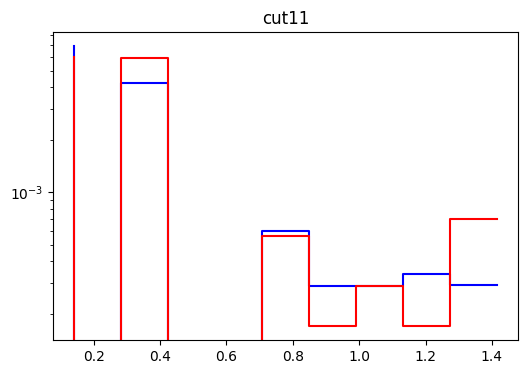

In [18]:
mean_energies_gsf = []
mean_energies_h3a = []
mean_atomic_gsf = []
mean_atomic_h3a = []

for i, cut in enumerate(cuts):
    mean_energy_gsf = np.average(log_true_E[cut], weights = gsf[cut])
    mean_energy_h3a = np.average(log_true_E[cut], weights = h3a[cut])
    mean_logz_gsf = np.average(np.log10(atomic_number[cut]), weights = gsf[cut])
    mean_logz_h3a = np.average(np.log10(atomic_number[cut]), weights = h3a[cut])

    mean_energies_gsf.append(mean_energy_gsf)
    mean_energies_h3a.append(mean_energy_h3a)
    mean_atomic_gsf.append(mean_logz_gsf)
    mean_atomic_h3a.append(mean_logz_h3a)

    bin_gsf, edge_gsf = np.histogram(np.log10(atomic_number[cut]), weights = gsf[cut])
    bin_h3a, edge_h3a = np.histogram(np.log10(atomic_number[cut]), weights = h3a[cut])
    plt.figure(figsize = (6, 4))
    plt.step(edge_gsf[1:], bin_gsf, 'b')
    plt.step(edge_h3a[1:], bin_h3a, 'r')
    plt.yscale('log')
    plt.title(f"cut{i}")
    plt.show()

mean_energies_gsf = np.array(mean_energies_gsf)
mean_energies_h3a = np.array(mean_energies_h3a)
mean_atomic_gsf = np.array(mean_atomic_gsf)
mean_atomic_h3a = np.array(mean_atomic_h3a)

In [19]:
total_n_gsf, total_edges_gsf = np.histogram(log_true_E, bins = mean_energies_gsf, weights = gsf)
total_n_h3a, total_edges_h3a = np.histogram(log_true_E, bins = mean_energies_h3a, weights = h3a)

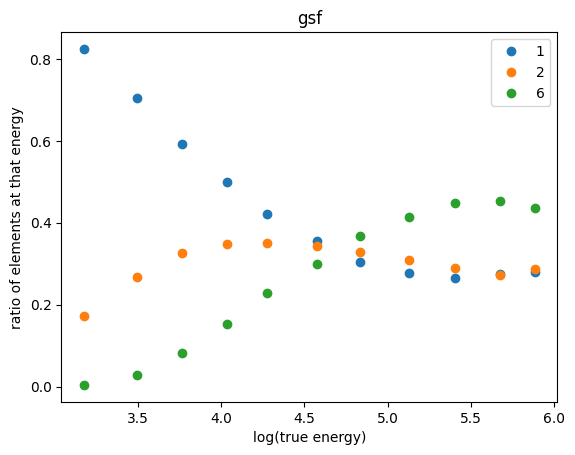

In [20]:
# for i in np.unique(atomic_number):
# gsf
for i in [1,2,6]:
    if i >= 6:
        ni, ei = np.histogram(log_true_E[atomic_number >= i], bins = mean_energies_gsf, weights = gsf[atomic_number >= i])
    else:
        ni, ei = np.histogram(log_true_E[atomic_number == i], bins = mean_energies_gsf, weights = gsf[atomic_number == i])

    frac = ni/total_n_gsf
    plt.plot(ei[1:], frac, 'o',label=str(i))
plt.title("gsf")
plt.xlabel("log(true energy)")
plt.ylabel("ratio of elements at that energy")
plt.legend()
plt.show()

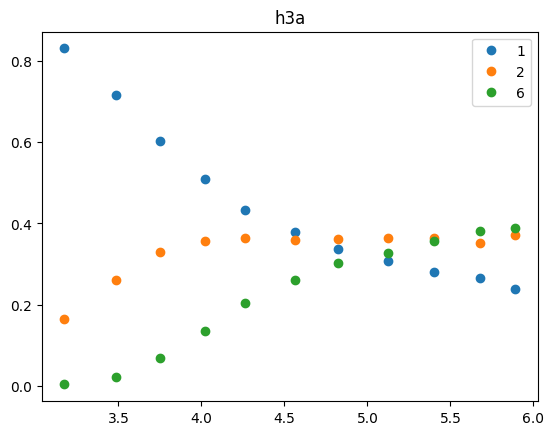

In [21]:
# h3a
for i in [1,2,6]:
    if i >= 6:
        ni, ei = np.histogram(log_true_E[atomic_number >= i], bins = mean_energies_h3a, weights = h3a[atomic_number >= i])
    else:
        ni, ei = np.histogram(log_true_E[atomic_number == i], bins = mean_energies_h3a, weights = h3a[atomic_number == i])

    frac = ni/total_n_h3a
    plt.plot(ei[1:], frac, 'o',label=str(i))
plt.title("h3a")
plt.legend()
plt.show()

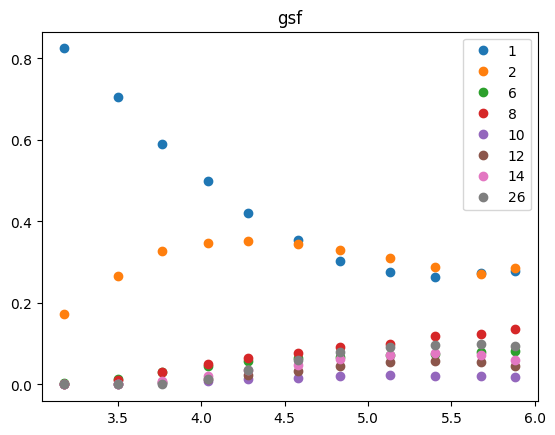

In [22]:
# gsf
for i in np.unique(atomic_number):
    ni, ei = np.histogram(log_true_E[atomic_number == i], bins = mean_energies_gsf, weights = gsf[atomic_number == i])

    frac = ni/ total_n_gsf
    plt.plot(ei[1:], frac, 'o', label = str(i))

plt.title("gsf")
plt.legend()
plt.show()

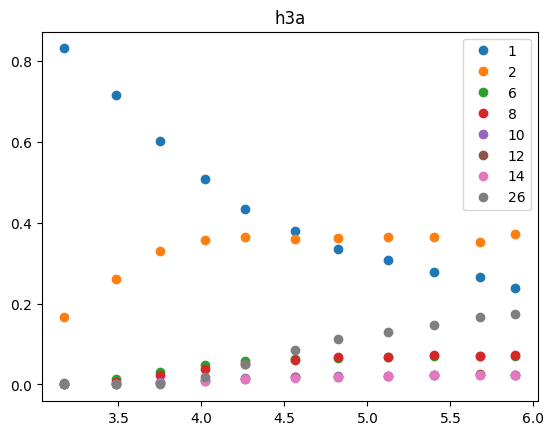

In [23]:
# h3a
for i in np.unique(atomic_number):
    ni, ei = np.histogram(log_true_E[atomic_number == i], bins = mean_energies_h3a, weights = h3a[atomic_number == i])

    frac = ni/ total_n_h3a
    plt.plot(ei[1:], frac, 'o', label = str(i))

plt.title("h3a")
plt.legend()
plt.show()

In [24]:
mean_rid_gsf = mean_energies_gsf - mean_atomic_gsf
mean_rid_gsf

array([2.80205048, 3.03208803, 3.31438517, 3.56712851, 3.80969053,
       4.02567307, 4.28745949, 4.51749759, 4.80888662, 5.08947799,
       5.37691748, 5.64234591])

In [25]:
mean_rid_h3a = mean_energies_h3a - mean_atomic_h3a
mean_rid_h3a

array([2.81710572, 3.03712762, 3.31220047, 3.56421796, 3.81369619,
       4.03916496, 4.31332902, 4.54941748, 4.8367598 , 5.10255633,
       5.37360702, 5.61040444])

# IceCube - Reading and viewing the files

- nchannel: number of active channels
- llhZen: reconstructed zenith
- llhAz: reconstructed azimuth
- zenith: zenith angle
- azimuth: azimuth angle
- mc_energy: true energy
- type: proton, helium, nitrogen, aluminium, iron
- energy: true energy
- GaisserH3a: weights
- Hoerandel: weights
- GlobalFitGST: weights
- reco_energy: reconstructed energy

In [26]:
dst = np.load('dst_20904_v2.npz')

print(dst.files)

# accessing individual numpy arrays from the file
# dst['zenith']

['nchannel', 'llhZen', 'llhAz', 'zenith', 'azimuth', 'mc_energy', 'type', 'isgoodllh', 'ndir', 'ldir', 'rlogl', 'atmosphere', 'TriggID_1006', 'energy', 'GaisserH3a', 'Hoerandel', 'GlobalFitGST', 'GlobalSplineFit5Comp', 'reco_energy']


[4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 6, 6.5]

bin edges in log for the reco energy

# IceCube - Applying initial cuts

In [27]:
imain_cut = np.logical_and(dst['nchannel'] > 10, dst['llhZen'] < 70)

ienergy = np.log10(dst['energy'][imain_cut])
weights_h3a = dst['GaisserH3a'][imain_cut]
# weights_2 = dst['Hoerandel'][imain_cut]
weights_gsf = dst['GlobalSplineFit5Comp'][imain_cut]
ireco_energy = dst['reco_energy'][imain_cut]
inchannel = dst['nchannel'][imain_cut]
ireco_zenith = dst['llhZen'][imain_cut]
izenith = dst['zenith'][imain_cut]
itype = dst['type'][imain_cut]

iparticle_ids = {2212: 1, 1000020040: 2, 1000070140: 7, 1000130270: 13, 1000260560: 26}

In [28]:
# get the atomic number from the particle ids for each particle
iatomic = []
for i in itype:
    iatomic.append(iparticle_ids[i])

iatomic = np.array(iatomic)
log_iatomic = np.log10(iatomic)

Rigidity equation: \
R = E / Z \
\$ log(R) = log(E) - log(Z) \$

In [29]:
# get the rigidity for each event
# this is a numpy array
irigidity = ienergy - log_iatomic

# Approach
- argsort on reco energy
- apply it on all the other arrays
- define the cdf and weighted ks test functions
- use the vectorized approach and traverse the reco energy array to get windows
- for each window, find the cdf of both hawc and icecube and then perform the weighted ks test
- store the distance somewhere associated to that window
- find the minimum difference and identify that window
- that will be the most compatible to hawc
- do this for all the hawc bins
- store the emin and emax for later use

## Argsorting the array

In [30]:
# argsort on reco_energy and apply it to all the other arrays
order = np.argsort(ireco_energy)
# true energy
ienergy = ienergy[order]
# atomic number
iatomic = iatomic[order]
# log of atomic number
log_iatomic = log_iatomic[order]
# gsf weights
weights_gsf = weights_gsf[order]
# h3a weights
weights_h3a = weights_h3a[order]
# reconstructed energy
ireco_energy = ireco_energy[order]
# rigidity
irigidity = irigidity[order]

## Mean rigidity function

In [31]:
# get the mean rigidity for a subarray of energy and atomic number and applying the weights for them
def get_mean_rigidity(ienergy_array, iatomic_array, weight_array):
    rigidity_values = ienergy_array - np.log10(iatomic_array)
    return np.average(rigidity_values, weights=weight_array)

## Weighted cumulative distribution function

In [32]:
# empirical cumulative distribution function - here empirical stands for real world observations
# returns x_sorted - sorted values, cdf - the cumulative distribution (from 0 to 1)
def weighted_ecdf(energy, weights):
    
    # Sort by the values
    order = np.argsort(energy)
    x_sorted = energy[order]
    w_sorted = weights[order]

    # Weighted cumulative sum
    cum_w = np.cumsum(w_sorted)
    total_w = cum_w[-1] # last value of the weights will be the total sum of all the weights

    # normalizing the cdf
    cdf = cum_w / total_w
    return x_sorted, cdf

## Plotting the weighted ecdf function

In [33]:
# weighted ecdf by seaborn along with a plot.
def plot_ecdf(x_sorted, cdf):
    plt.figure(figsize=(6,4))
    plt.plot(x_sorted, cdf, 'bo')
    plt.xlabel('energy')
    plt.ylabel('cdf of weights')
    plt.show()

## Weighted KS test function
- this won't return a p-value and the p-value is not useful anyways because HAWC and IceCube have very different cdfs

In [34]:
def weighted_ks_2samp(hawc_data, hawc_weights, icecube_data, icecube_weights):
    """
    Weighted two-sample Kolmogorov-Smirnov test (no p-value).
    Returns:
        ks_stat : the maximum distance between the two weighted CDFs
    """
    # this will return a normalized ecdf
    x1_sorted, cdf1 = weighted_ecdf(hawc_data, hawc_weights)
    x2_sorted, cdf2 = weighted_ecdf(icecube_data, icecube_weights)

    # initializing the counters
    i1 = 0
    i2 = 0
    d_max = 0.0
    n1 = len(x1_sorted)
    n2 = len(x2_sorted)

    # initializing cdf values
    c1 = 0.0
    c2 = 0.0

    # are we iterating through all the values of the energy data????
    # this while loop is a very time consuming step
    # make this better
    while i1 < n1 and i2 < n2:
        v1 = x1_sorted[i1]
        v2 = x2_sorted[i2]
        if v1 < v2:
            c1 = cdf1[i1]
            i1 += 1
        elif v2 < v1:
            c2 = cdf2[i2]
            i2 += 1
        else:
            c1 = cdf1[i1]
            c2 = cdf2[i2]
            i1 += 1
            i2 += 1
        d = abs(c1 - c2)
        if d > d_max:
            d_max = d

    # If one array is exhausted, continue stepping through the other
    # need to make this a conditional thing instead of two more while loops
    # three while loops will take a lot of time
    while i1 < n1:
        # dont need this again
        c1 = cdf1[i1]
        i1 += 1
        d = abs(c1 - c2)
        if d > d_max:
            d_max = d

    while i2 < n2:
        # same here
        c2 = cdf2[i2]
        i2 += 1
        d = abs(c1 - c2)
        if d > d_max:
            d_max = d

    return d_max  # no p-value for the weighted case

## Optimized weighted ks test function

In [35]:
def weighted_ks_2samp_optimized(x1_sorted, cdf1, x2_sorted, cdf2):
    i1, i2 = 0, 0
    d_max = 0.0
    c1, c2 = 0.0, 0.0
    n1, n2 = len(x1_sorted), len(x2_sorted)

    while i1 < n1 or i2 < n2:
        
        if i2 >= n2 or (i1 < n1 and x1_sorted[i1] < x2_sorted[i2]):
            c1 = cdf1[i1]
            i1 += 1
            
        elif i1 >= n1 or x2_sorted[i2] < x1_sorted[i1]:
            c2 = cdf2[i2]
            i2 += 1
            
        else:
            c1 = cdf1[i1]
            c2 = cdf2[i2]
            i1 += 1
            i2 += 1

        d = abs(c1 - c2)
        if d > d_max:
            d_max = d

    return d_max

## Vectorized KS test function
- this one is using interpolation (np.interp)

In [36]:
def weighted_ks_2samp_vectorized(x1, w1, x2, w2):
    
    x1_sorted, cdf1 = weighted_ecdf(x1, w1)
    x2_sorted, cdf2 = weighted_ecdf(x2, w2)
    # For each point in x1_sorted, interpolate the CDF of sample 2.
    interp_cdf2 = np.interp(x1_sorted, x2_sorted, cdf2, left=0, right=1)
    d1 = np.max(np.abs(cdf1 - interp_cdf2))
    # Repeat in reverse: for each point in x2_sorted, interpolate the CDF of sample 1.
    interp_cdf1 = np.interp(x2_sorted, x1_sorted, cdf1, left=0, right=1)
    d2 = np.max(np.abs(cdf2 - interp_cdf1))
    
    return max(d1, d2)

## Final KS test function

In [37]:
def ks_w2(data1, data2, wei1, wei2):

    # Sort each data set
    idx1 = np.argsort(data1)
    idx2 = np.argsort(data2)
    d1_sorted = data1[idx1]
    w1_sorted = wei1[idx1]
    d2_sorted = data2[idx2]
    w2_sorted = wei2[idx2]

    cwei1 = np.concatenate((
        [0],
        np.cumsum(w1_sorted) / w1_sorted.sum()
    ))
    cwei2 = np.concatenate((
        [0],
        np.cumsum(w2_sorted) / w2_sorted.sum()
    ))

    merged = np.concatenate((d1_sorted, d2_sorted))
    merged_sorted = np.unique(np.sort(merged))

    cdf1_idx = np.searchsorted(d1_sorted, merged_sorted, side='right')
    cdf2_idx = np.searchsorted(d2_sorted, merged_sorted, side='right')
    cdf1we = cwei1[cdf1_idx]
    cdf2we = cwei2[cdf2_idx]

    return np.max(np.abs(cdf1we - cdf2we))

## Mean icecube energy function

In [38]:
def get_mean_icecube_energy(ienergy_array, weight_array):
    return np.average(ienergy_array, weights=weight_array)

## Vectorized sliding window approach implementation

In [39]:
# building candidate windows for the vectorized approach
N = len(ireco_energy)
window_width = 0.25

j_indices = np.searchsorted(ireco_energy, ireco_energy + window_width, side='left')
valid_mask = j_indices > np.arange(N)
valid_idx = np.where(valid_mask)[0]

In [40]:
# store the emin and emax values for each valid candidate window
# candidate_emin = ireco_energy[valid_idx]
# initializing the emax array with 0's
# candidate_emax = np.empty_like(candidate_emin)
candidate_start_idx = valid_idx
candidate_end_idx = j_indices[valid_idx]

In [41]:
print("total number of windows: ", candidate_start_idx)

total number of windows:  [      0       1       2 ... 2277940 2277941 2277942]


In [42]:
# iterate through the start index array and find the value at the end index
# this value is the vaid emax value
# populate the emax array
# for k, i_start in enumerate(candidate_start_idx):
#     i_end = candidate_end_idx[k]
#     candidate_emax[k] = ireco_energy[i_end - 1]

In [43]:
# print(candidate_emax)

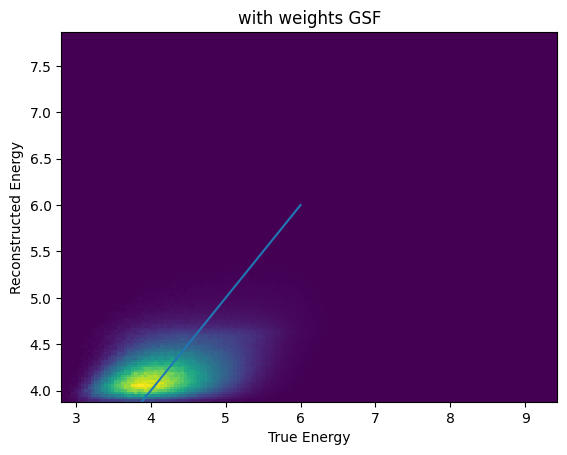

In [44]:
plt.hist2d(ienergy, ireco_energy, bins = 150, weights = weights_gsf)
plt.plot(np.linspace(3,6), np.linspace(3,6))
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights GSF')
plt.show()

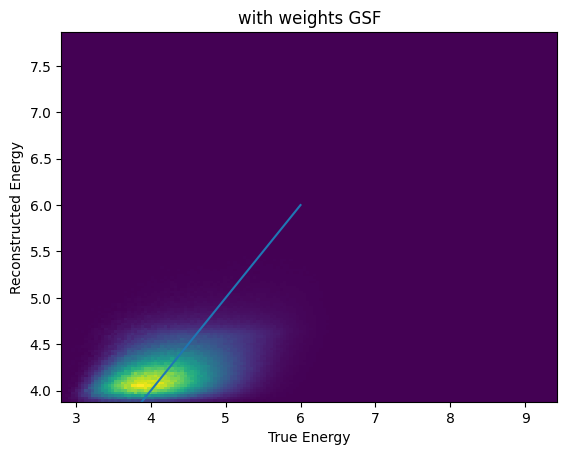

In [45]:
plt.hist2d(ienergy, ireco_energy, bins = 150, weights = weights_h3a)
plt.plot(np.linspace(3,6), np.linspace(3,6))
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights GSF')
plt.show()

## KS Test between HAWC and IceCube data

### step apprach
- chooses windows based on the step, so less accurate but faster
- to make it more accurate, after this coarse search, can do a refined search around the energy ranges

In [ ]:
all_ks_values_coarse = np.load('/data/user/rykore/hawc_icecube_files/all_ks_values.npy', allow_pickle = True).item()
best_ks_values = np.load('/data/user/rykore/hawc_icecube_files/best_ks_values.npy', allow_pickle = True).item()
ienergy_ranges = np.load('/data/user/rykore/hawc_icecube_files/ienergy_ranges.npy', allow_pickle = True).item()

### don't run this again unless necessary
- need to do this again for h3a

In [46]:
# save the arrays you need using np.save() and use it later
step_size = max(1, len(candidate_start_idx) // 1000)
refine_margin = 1000
candidate_indices_coarse = np.arange(0, len(candidate_start_idx), step_size)
all_ks_values_coarse = []
best_ks_values = []
energy_ranges = []

start = time.time()
for i, cut in enumerate(cuts):
    print("cut ", i)
    hawc_rigidity = rigidity[cut]
    hawc_weights = gsf[cut]

    ks_value = np.full(len(candidate_indices_coarse), np.nan)

    # coarse search
    for i, cand_idx in enumerate(candidate_indices_coarse):
        i_start = candidate_start_idx[cand_idx]
        i_end = candidate_end_idx[cand_idx]
        cand_rig = irigidity[i_start:i_end]
        cand_w = weights_gsf[i_start:i_end]

        if cand_rig.size == 0:
            continue

        ks_val = ks_w2(hawc_rigidity, cand_rig, hawc_weights, cand_w)
        ks_value[i] = ks_val

    # this will give all the ks values for all the bins
    all_ks_values_coarse.append(ks_value)
    best_idx = np.nanargmin(ks_value)
    print("coarse ks value: ", ks_value[best_idx])
    best_cand = candidate_indices_coarse[best_idx]

    # refined search on the just found best_candidate
    refine_start = max(0, best_cand - refine_margin)
    refine_end = min(len(candidate_start_idx), best_cand + refine_margin)
    refined_ks_values = np.full(refine_end - refine_start, np.nan)

    for j, cand_id in enumerate(range(refine_start, refine_end)):
        i_start = candidate_start_idx[cand_id]
        i_end = candidate_end_idx[cand_id]
        cand_rig = irigidity[i_start:i_end]
        cand_w = weights_gsf[i_start:i_end]
        
        if cand_rig.size == 0:
            continue

        ks_val = ks_w2(hawc_rigidity, cand_rig, hawc_weights, cand_w)
        refined_ks_values[j] = ks_val

    # get and store the best ks statistic
    refined_best_idx = np.nanargmin(refined_ks_values)
    refined_best_cand = refine_start + refined_best_idx
    best_ks_refined = refined_ks_values[refined_best_idx]
    print("refined ks value: ", best_ks_refined)
    best_ks_values.append(best_ks_refined)

    # get the final energy ranges
    i_start_final = candidate_start_idx[refined_best_cand]
    i_end_final = candidate_end_idx[refined_best_cand]
    energy_ranges.append([ireco_energy[i_start_final], ireco_energy[i_end_final]])
    print()

end = time.time()
print("total time: ", (end - start)/60, " minutes")

cut  0
coarse ks value:  0.8556879662227658
refined ks value:  0.8556793960585414

cut  1
coarse ks value:  0.7524406109431798
refined ks value:  0.7524258622726422

cut  2
coarse ks value:  0.5673127015129544
refined ks value:  0.5672984914330614

cut  3
coarse ks value:  0.3350041506379864
refined ks value:  0.33497990253727633

cut  4
coarse ks value:  0.12071112093333536
refined ks value:  0.12068890455146353

cut  5
coarse ks value:  0.06150774674489051
refined ks value:  0.06137501402904344

cut  6
coarse ks value:  0.06527097948185956
refined ks value:  0.06523097671099531

cut  7
coarse ks value:  0.0882418392722586
refined ks value:  0.08814590157150493

cut  8
coarse ks value:  0.09902178914787318
refined ks value:  0.09867657923164863

cut  9
coarse ks value:  0.10465784562986102
refined ks value:  0.1030992785805277

cut  10
coarse ks value:  0.11355069107794502
refined ks value:  0.10742362975150233

cut  11
coarse ks value:  0.18647196944679978
refined ks value:  0.179465

In [48]:
for bin_idx, (best_val, range_val) in enumerate(zip(best_ks_values, energy_ranges)):
    print(f"HAWC bin {bin_idx}: Best KS = {best_val}, Energy Range = [{range_val[0]}, {range_val[1]}]")

HAWC bin 0: Best KS = 0.8556793960585414, Energy Range = [3.880659818649292, 4.130676746368408]
HAWC bin 1: Best KS = 0.7524258622726422, Energy Range = [3.880659818649292, 4.130676746368408]
HAWC bin 2: Best KS = 0.5672984914330614, Energy Range = [3.880659818649292, 4.130676746368408]
HAWC bin 3: Best KS = 0.33497990253727633, Energy Range = [3.880659818649292, 4.130676746368408]
HAWC bin 4: Best KS = 0.12068890455146353, Energy Range = [3.8806605339050293, 4.130676746368408]
HAWC bin 5: Best KS = 0.06137501402904344, Energy Range = [4.030068874359131, 4.28007173538208]
HAWC bin 6: Best KS = 0.06523097671099531, Energy Range = [4.344851970672607, 4.59486198425293]
HAWC bin 7: Best KS = 0.08814590157150493, Energy Range = [4.639890670776367, 4.889894485473633]
HAWC bin 8: Best KS = 0.09867657923164863, Energy Range = [4.996903896331787, 5.246922016143799]
HAWC bin 9: Best KS = 0.1030992785805277, Energy Range = [5.403433799743652, 5.653448581695557]
HAWC bin 10: Best KS = 0.1074236297

In [49]:
# save all the arrays just calculated
np.save('/data/user/rykore/hawc_icecube_files/best_ks_values.npy', best_ks_values)
np.save('/data/user/rykore/hawc_icecube_files/all_ks_values.npy', all_ks_values_coarse)
np.save('/data/user/rykore/hawc_icecube_files/ienergy_ranges.npy', energy_ranges)

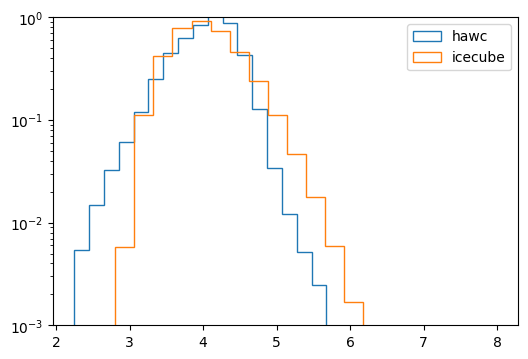

In [50]:
icut = np.logical_and(ireco_energy >=  4.030068874359131, ireco_energy < 4.28007173538208)
plt.figure(figsize = (6,4))
plt.hist(rigidity[cuts[5]], bins = 20, weights=gsf[cuts[5]], histtype='step', density = True, label = 'hawc')
plt.hist(irigidity[icut], bins = 20, weights=weights_gsf[icut], histtype= 'step', density = True, label = 'icecube')
plt.semilogy()
plt.ylim(10**-3, 1)
plt.legend()
plt.show()

### test for one bin - don't run this

In [45]:
# this is just for the gsf weights
# testing the code out with one hawc bin and checking the ks stat for all icecube bins
step_size = max(1, len(candidate_start_idx) // 1000)
candidate_indices_coarse = np.arange(0, len(candidate_start_idx), step_size)

hawc_rigidity = rigidity[cuts[5]]
hawc_weights  = gsf[cuts[5]]

# just to check how the code is working, we use hawc's cut 5
# can iterate through the hawc cuts later
# hawc_sorted, hawc_cdf = weighted_ecdf(log_true_E[cuts[5]], gsf[cuts[5]])
ks_values = np.full(len(candidate_indices_coarse), np.nan)    

start_time = time.time()
# loop through the windows and find the most minimum distance from the ks test
for i, cand_idx in enumerate(candidate_indices_coarse):
    i_start = candidate_start_idx[cand_idx]
    i_end   = candidate_end_idx[cand_idx]
    cand_rig = irigidity[i_start:i_end]
    cand_w   = weights_gsf[i_start:i_end]
    if cand_rig.size == 0:
        continue
    # Weighted KS test on "rigidity"
    # data1 = hawc_rigidity, data2 = cand_rig
    ks_val = ks_w2(hawc_rigidity, cand_rig, hawc_weights, cand_w)
    ks_values[i] = ks_val

end_time = time.time()
print(f"Time for coarse search: {end_time - start_time} seconds")

Time for coarse search: 120.22568702697754 seconds


In [46]:
best_idx = np.nanargmin(ks_values)
best_ks  = ks_values[best_idx]
best_cand = candidate_indices_coarse[best_idx]
i_start = candidate_start_idx[ best_cand ]
i_end   = candidate_end_idx[ best_cand ]

print(f"Best KS = {best_ks} at candidate index = {best_cand}")
print(f"Candidate window in reco energy: [ {ireco_energy[i_start]:.3f}, {ireco_energy[i_end-1]:.3f} ]")

Best KS = 0.06150774674489051 at candidate index = 241362
Candidate window in reco energy: [ 4.030, 4.280 ]


In [47]:
# refined search for the testing code
refine_margin = 1000

# so you go 1000 windows before and after the selected coarse search energy range to check for accuracy
refine_start = max(0, best_cand - refine_margin)
refine_end = min(len(candidate_start_idx), best_cand + refine_margin)

# array to store refined ks values
refined_ks_values = np.full(refine_end - refine_start, np.nan)

start = time.time()
for j, cand_id in enumerate(range(refine_start, refine_end)):
    i_start = candidate_start_idx[cand_id]
    i_end = candidate_end_idx[cand_id]
    cand_rig = irigidity[i_start:i_end]
    cand_w = weights_gsf[i_start:i_end]
    if cand_rig.size == 0:
        continue
    # Compute KS statistic for this candidate window:
    ks_val = ks_w2(hawc_rigidity, cand_rig, hawc_weights, cand_w)
    refined_ks_values[j] = ks_val

end = time.time()

refined_best_idx = np.nanargmin(refined_ks_values)
refined_best_cand = refine_start + refined_best_idx
best_ks_refined = refined_ks_values[refined_best_idx]

i_start_final = candidate_start_idx[refined_best_cand]
i_end_final = candidate_end_idx[refined_best_cand]
final_energy_range = [ireco_energy[i_start_final], ireco_energy[i_end_final-1]]
final_mean_rigidity = np.average(irigidity[i_start_final:i_end_final],
                                 weights=weights_gsf[i_start_final:i_end_final])

print("Refined best candidate:")
print(f"  Energy Range: [{final_energy_range[0]:.3f}, {final_energy_range[1]:.3f}]")
print(f"  Refined KS Statistic: {best_ks_refined:.4f}")
print(f"  Mean IceCube Rigidity: {final_mean_rigidity:.3f} (log10 scale)")
print(f"Time taken: {(end - start)/60} minutes")

Refined best candidate:
  Energy Range: [4.030, 4.280]
  Refined KS Statistic: 0.0614
  Mean IceCube Rigidity: 4.059 (log10 scale)
Time taken: 6.38833843866984 minutes


## Energy cuts on reco energy and apply that on true energy

In [63]:
def cut_ienergy(min_energy, max_energy):
    icut = np.logical_and(ireco_energy >= min_energy, ireco_energy < max_energy)
    return icut

In [64]:
icuts = []

for e_range in energy_ranges:
    icut = cut_ienergy(e_range[0], e_range[1])
    icuts.append(icut)

In [67]:
imean_rigs_gsf = []

for i, icut in enumerate(icuts):
    imean_rig_gsf = np.average(irigidity[icut], weights = weights_gsf[icut])
    imean_rigs_gsf.append(imean_rig_gsf)

imean_rigs_gsf = np.array(imean_rigs_gsf)

In [68]:
imean_rigs_gsf

array([3.9555787 , 3.9555787 , 3.9555787 , 3.9555787 , 3.95556396,
       4.05872201, 4.31860767, 4.53008936, 4.81242199, 5.10161333,
       5.37621405, 5.59597529])

In [81]:
imean_energies_gsf = []

for i, icut in enumerate(icuts):
    imean_energy_gsf = np.average(ienergy[icut], weights = weights_gsf[icut])
    imean_energies_gsf.append(imean_energy_gsf)

imean_energies_gsf = np.array(imean_energies_gsf)

In [82]:
imean_energies_gsf

array([4.08110045, 4.08110045, 4.08110045, 4.08110045, 4.08108108,
       4.19051303, 4.47989818, 4.72932615, 5.06712086, 5.43873051,
       5.801642  , 6.08472626])

In [83]:
imean_atomics_gsf = []

for i, icut in enumerate(icuts):
    imean_atomic_gsf = np.average(iatomic[icut], weights = weights_gsf[icut])
    imean_atomics_gsf.append(imean_atomic_gsf)

imean_atomics_gsf = np.array(imean_atomics_gsf)

In [84]:
imean_atomics_gsf

array([1.75380045, 1.75380045, 1.75380045, 1.75380045, 1.75375692,
       1.80039169, 2.04072318, 2.38538691, 2.92762698, 3.73062161,
       4.80123935, 5.48694361])

# HAWC + IceCube combined tables

In [70]:
# rigidity and energy bins table
df1 = pd.DataFrame()

df1['HAWC mean rid gsf'] = mean_rid_gsf
# df1['HAWC mean rid h3a'] = mean_rid_h3a
df1['HAWC (emin, emax)'] = list(zip(min_energies, max_energies))
df1['IceCube mean rid gsf'] = imean_rigs_gsf
# df1['IceCube mean rid h3a'] = mean_irid_h3a
df1['IceCube (emin, emax) gsf'] = energy_ranges
# df1['IceCube (emin, emax) h3a'] = icuts_h3a
df1

,HAWC mean rid gsf,"HAWC (emin, emax)",IceCube mean rid gsf,"IceCube (emin, emax) gsf"
0,2.802050,"(3.0, 3.51)",3.955579,"[3.880659818649292, 4.130676746368408]"
1,3.032088,"(3.51, 3.74)",3.955579,"[3.880659818649292, 4.130676746368408]"
2,3.314385,"(3.74, 3.98)",3.955579,"[3.880659818649292, 4.130676746368408]"
3,3.567129,"(3.98, 4.21)",3.955579,"[3.880659818649292, 4.130676746368408]"
4,3.809691,"(4.21, 4.433)",3.955564,"[3.8806605339050293, 4.130676746368408]"
5,4.025673,"(4.433, 4.648)",4.058722,"[4.030068874359131, 4.28007173538208]"
6,4.287459,"(4.648, 4.98)",4.318608,"[4.344851970672607, 4.59486198425293]"
7,4.517498,"(4.88, 5.15)",4.530089,"[4.639890670776367, 4.889894485473633]"
8,4.808887,"(5.15, 5.44)",4.812422,"[4.996903896331787, 5.246922016143799]"
9,5.089478,"(5.44, 5.68)",5.101613,"[5.403433799743652, 5.653448581695557]"


In [71]:
# # mean energies table
# df2 = pd.DataFrame()

# df2['HAWC gsf'] = mean_energies_gsf
# df2['HAWC h3a'] = mean_energies_h3a
# df2['IceCube gsf'] = mean_E_gsf
# df2['IceCube h3a'] = mean_E_h3a
# df2

# HAWC + IceCube Combined plots

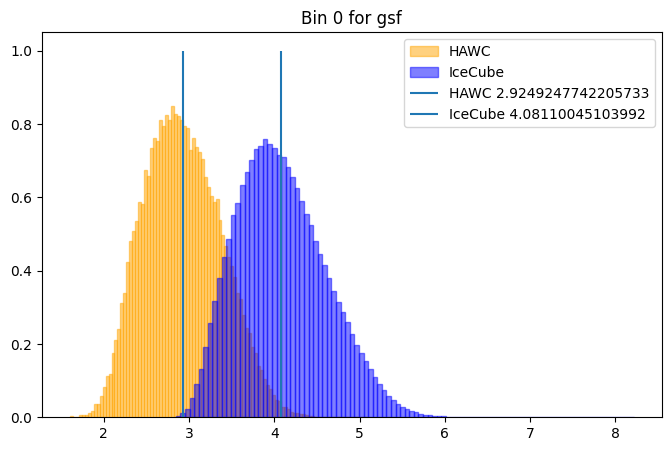

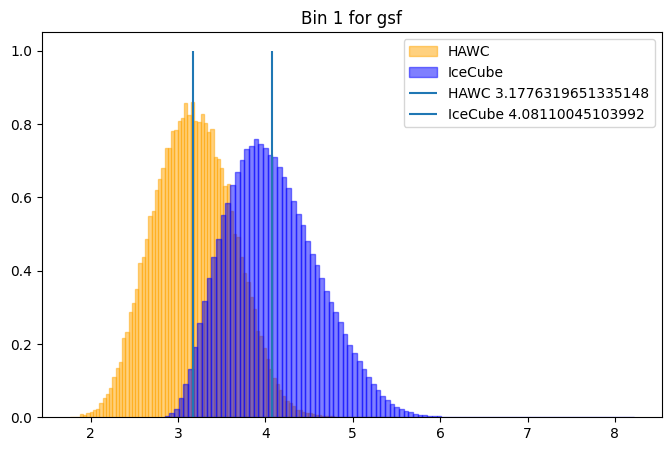

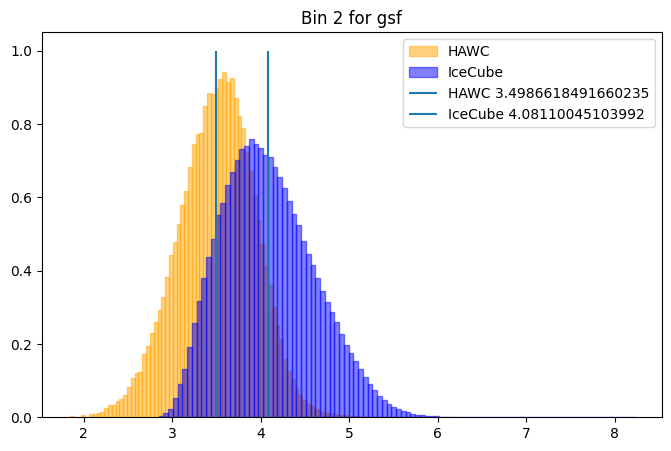

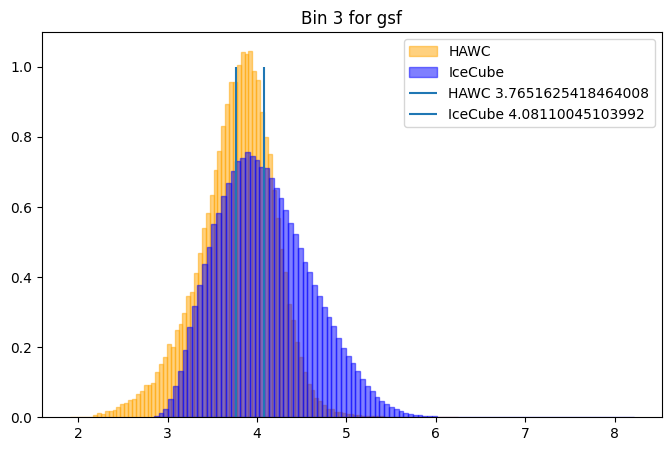

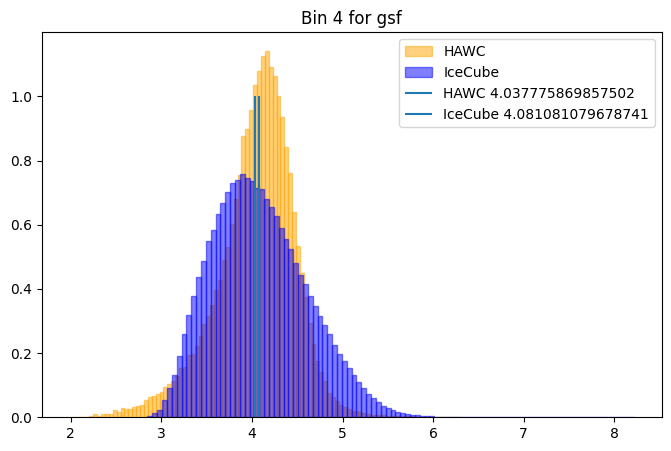

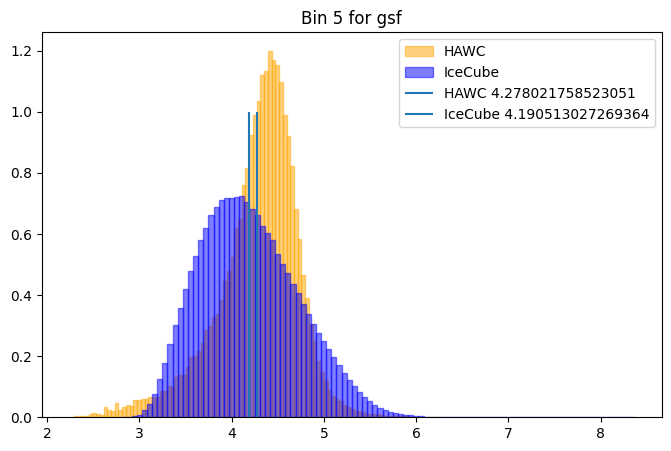

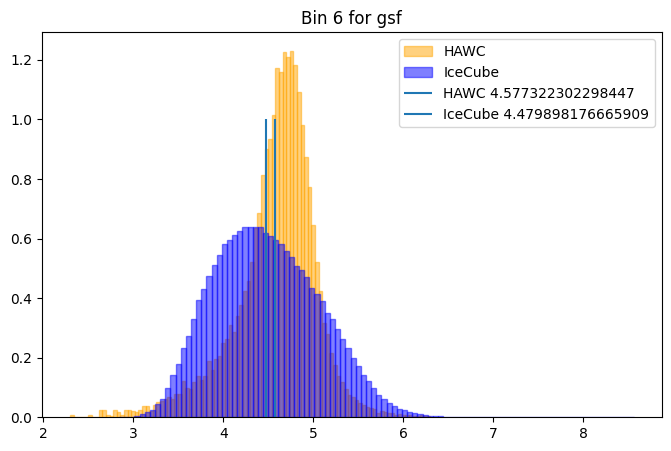

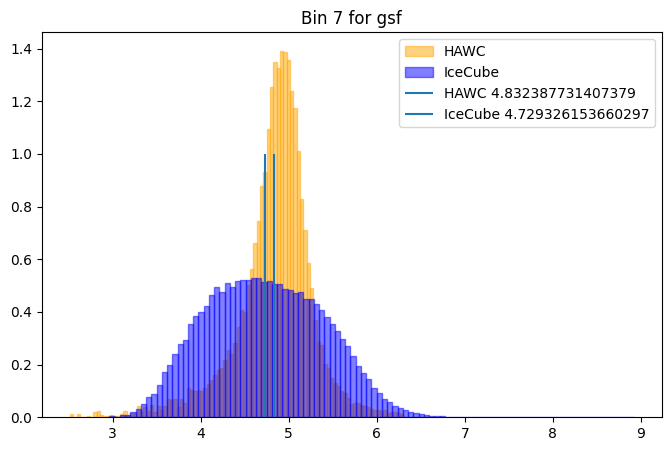

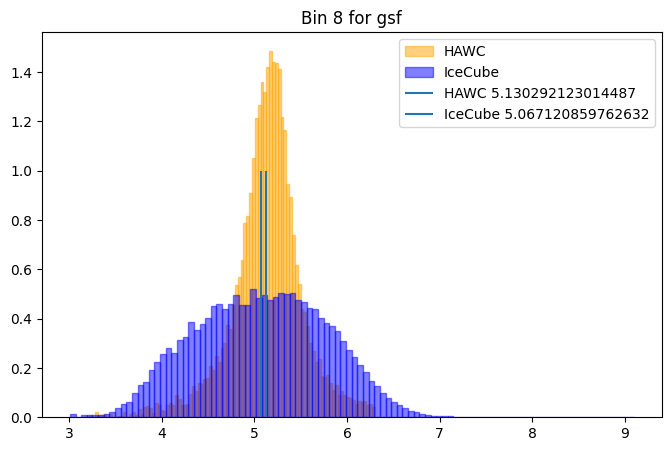

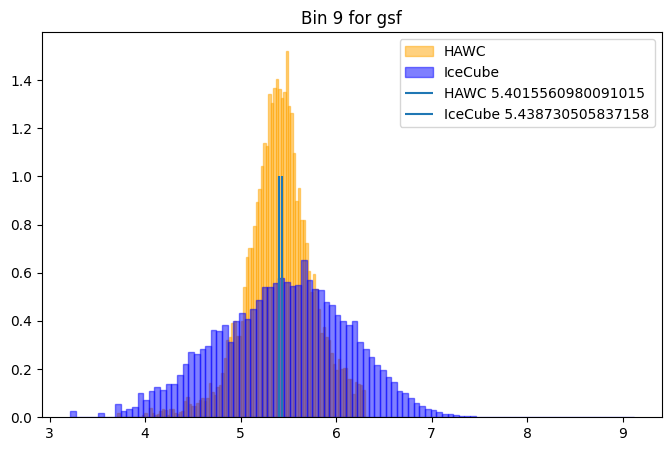

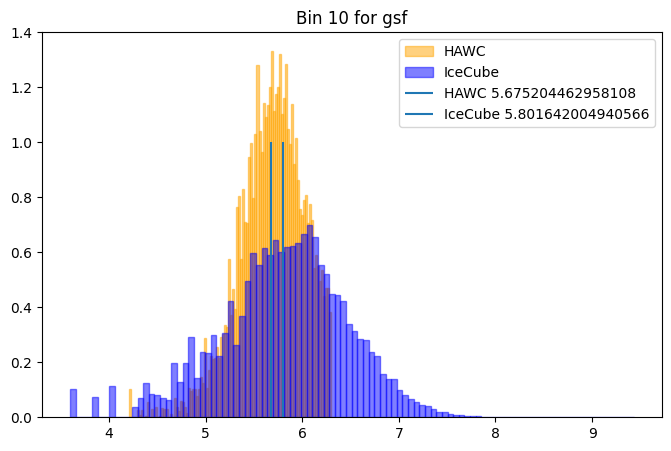

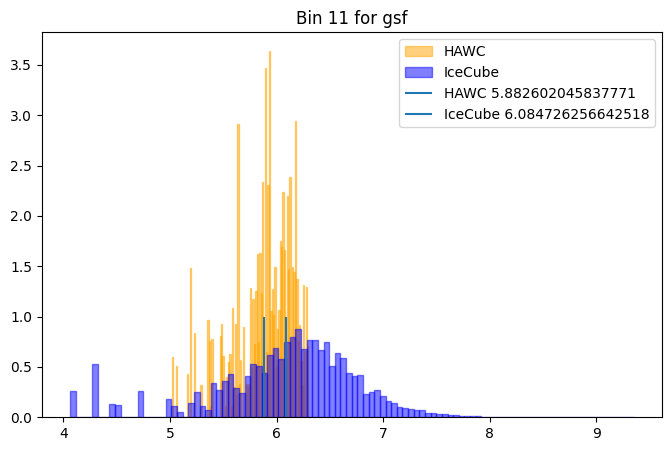

In [90]:
# colors = ["red", "blue", "orange", "green", "purple", "pink", "lime", "indigo", "gold", "yellowgreen", "peru", "rosybrown"]

# gsf
for idx, (i, j, k, l) in enumerate(zip(cuts, icuts, mean_energies_gsf ,imean_energies_gsf)):
    plt.figure(figsize = (8,5))
    plt.hist(log_true_E[i], bins = 100, weights = gsf[i], label = 'HAWC', alpha = 0.5, edgecolor = 'orange', color = 'orange', density = True)
    plt.hist(ienergy[j], bins = 100, weights = weights_gsf[j], label = 'IceCube', alpha = 0.5, edgecolor = 'blue', color = 'blue', density = True)
    plt.vlines(k, ymin = 0, ymax = 1, label = f"HAWC {k}")
    plt.vlines(l, ymin = 0, ymax = 1, label = f"IceCube {l}")
    plt.legend()
    plt.title(f"Bin {idx} for gsf")
    plt.show()

In [72]:
# # h3a
# for i, j in zip(cuts, icecube_cuts_h3a):
#     plt.figure(figsize = (8,5))
#     plt.hist(log_true_E[i], bins = 100, weights = h3a[i], label = 'HAWC', alpha = 0.5, edgecolor = 'orange', color = 'orange', density = True)
#     plt.hist(ienergy[j], bins = 100, weights = weights_h3a[j], label = 'IceCube', alpha = 0.5, edgecolor = 'blue', color = 'blue', density = True)
#     plt.legend()
#     plt.show()

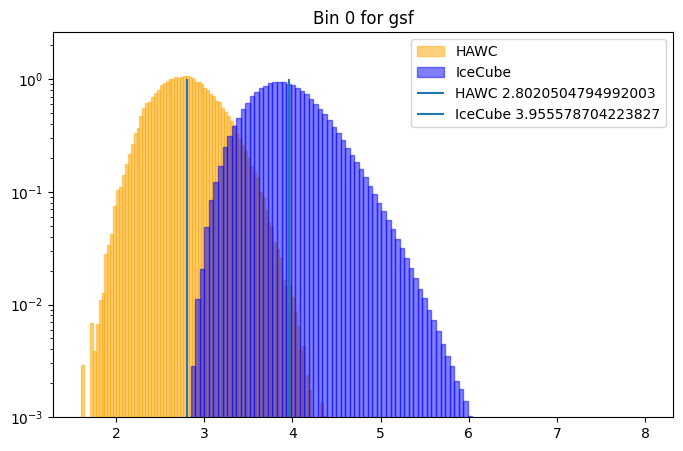

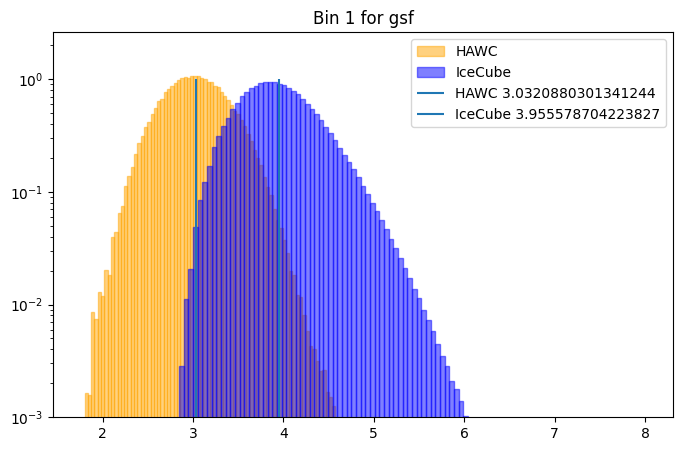

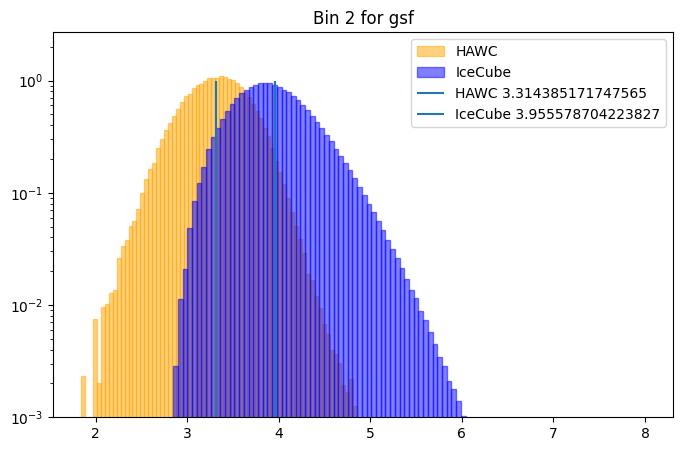

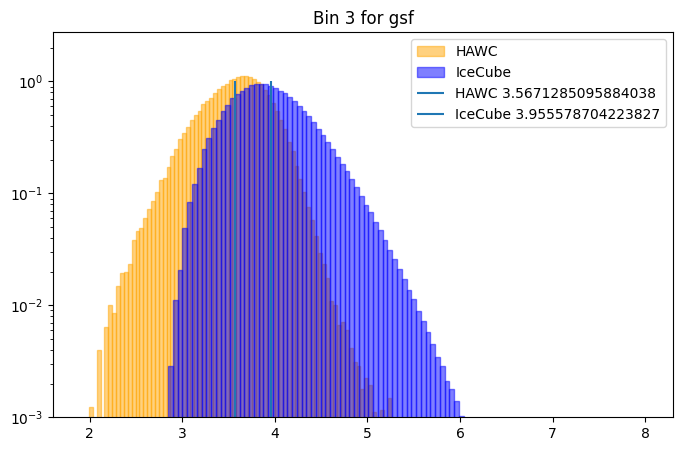

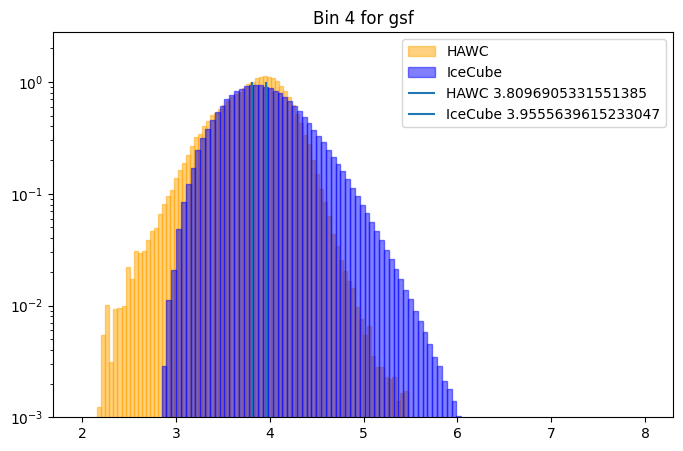

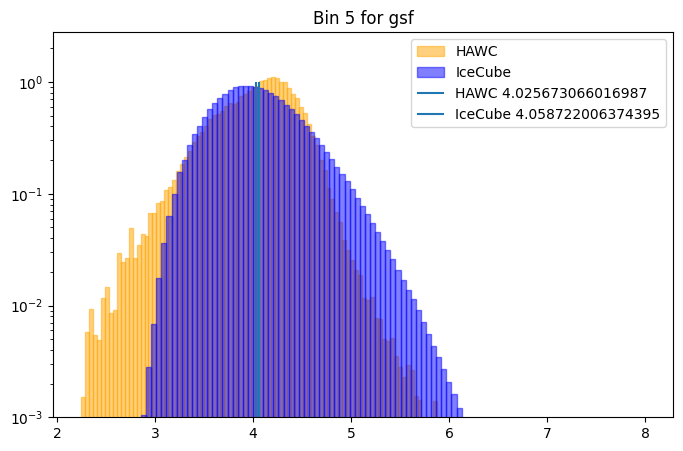

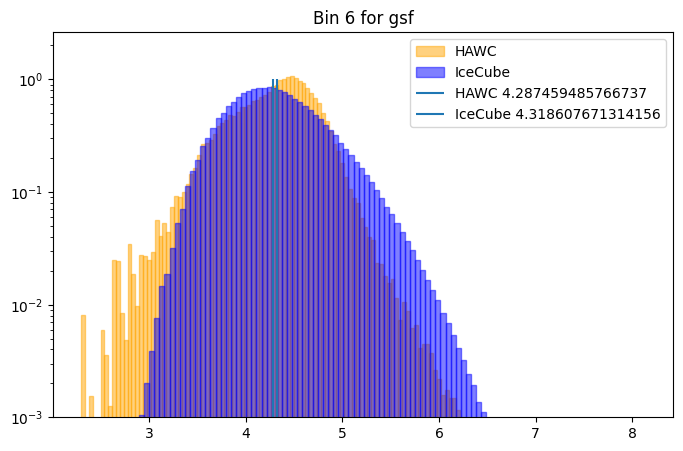

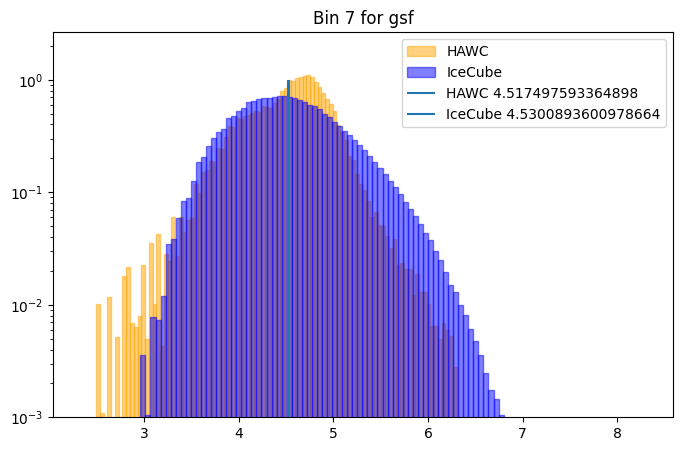

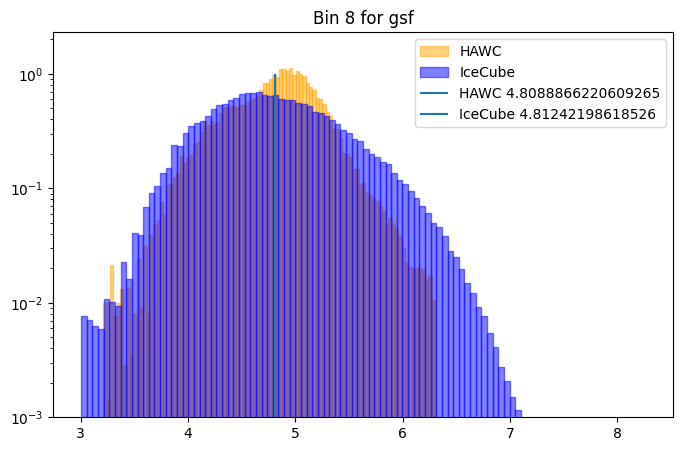

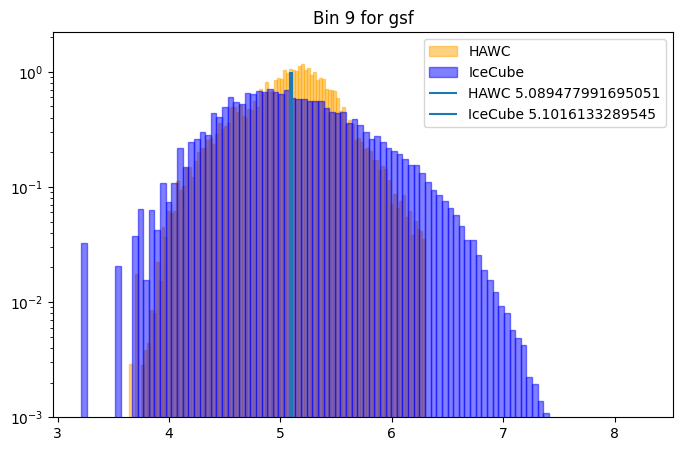

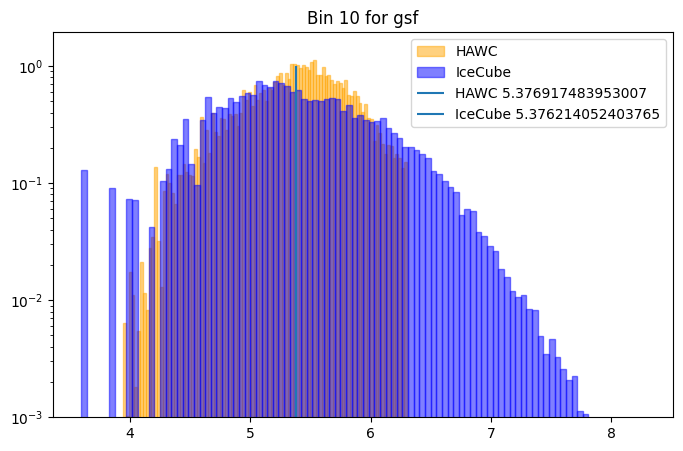

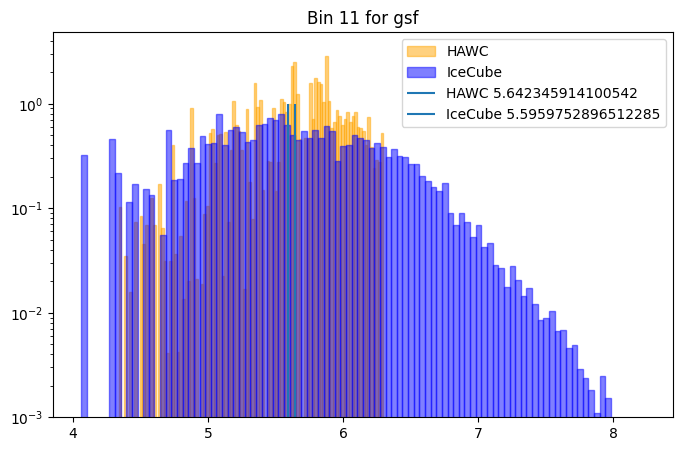

In [92]:
# colors = ["red", "blue", "orange", "green", "purple", "pink", "lime", "indigo", "gold", "yellowgreen", "peru", "rosybrown"]

# gsf
for idx, (i, j, k, l) in enumerate(zip(cuts, icuts, mean_rid_gsf ,imean_rigs_gsf)):
    plt.figure(figsize = (8,5))
    plt.hist(rigidity[i], bins = 100, weights = gsf[i], label = 'HAWC', alpha = 0.5, edgecolor = 'orange', color = 'orange', density = True)
    plt.hist(irigidity[j], bins = 100, weights = weights_gsf[j], label = 'IceCube', alpha = 0.5, edgecolor = 'blue', color = 'blue', density = True)
    plt.vlines(k, ymin = 0, ymax = 1, label = f"HAWC {k}")
    plt.vlines(l, ymin = 0, ymax = 1, label = f"IceCube {l}")
    plt.semilogy()
    plt.ylim(bottom = 10**-3)
    plt.legend()
    plt.title(f"Bin {idx} for gsf")
    plt.show()

In [73]:
# # h3a

# for i, j in zip(cuts, icecube_cuts_h3a):
#     plt.figure(figsize = (8,5))
#     plt.hist((log_true_E[i] - np.log10(atomic_number[i])), bins = 100, weights = h3a[i], label = 'HAWC', alpha = 0.5, edgecolor = 'orange', color = 'orange', density = True)
#     plt.hist((ienergy[j] - np.log10(iatomic[j])), bins = 100, weights = weights_h3a[j], label = 'IceCube', alpha = 0.5, edgecolor = 'blue', color = 'blue', density = True)
#     plt.legend()
#     plt.show()